# 14. Построение решения с использованием суперпозиции для переменного дебита 
Материалы курсов "Исследования скважин и пластов" и "Гидродинамические исследования скважин" в РГУ нефти и газа имени И.М.Губкина.

Версия 0.5 от 14.10.2022

Хабибуллин Ринат 2021 г.

---
[Открыть на google colab](https://colab.research.google.com/github/khabibullinra/welltest_examples/blob/master/jupyter/14_superposition_variable_rate.ipynb)

# Содержание

* [14.1 Расчет кривой восстановления давления ](#14.1) 
* [14.2 Случай для произвольной истории дебитов (ступенчатое изменение дебита)](#14.2) 
* [14.3 Случай для произвольной истории дебитов (линейное изменение дебита)](#14.3) 

In [1]:
# для того, чтобы скрипты гладко работали на https://colab.research.google.com/ пропишем
# установку библиотеки welltest
# библиотека welltest загружает определения функций для безразмерных переменных
# а также грузит anaflow которая обеспечивает работу с обратным преобразованием Лапласа

!pip install welltest

In [2]:
# импортируем библиотки, которые могут пригодиться для проведения расчетов
import numpy as np
import matplotlib.pyplot as plt
from anaflow import get_lap_inv
from scipy.special import kn, iv, expi

from welltest.functions import *

In [4]:
# Решение линейного стока уравнения фильтрации
def pd_ei(td, rd=1):
    """
    Решение линейного стока уравнения фильтрации
    rd - безразмерное расстояние
    td - безразмерное время
    """
    # при расчете убедимся, что td=0 не повлияет на расчет, даже если td массив и нулевой только один элемент
    td = np.array(td, dtype = float)
    return np.multiply(-0.5, 
                       expi(np.divide(-rd**2 / 4 , 
                                      td, 
                                      out=np.zeros_like(td), where=td!=0)), 
                       out=np.zeros_like(td), where=td!=0)

# 14.1 Расчет кривой восстановления давления <a class="anchor" id="14.1"></a>

Один из самых простых примеров применения суперпозиции. Предполагаем, что добывающая скважина в однородном изотропном пласте запускается в момент времени `t=0` и работает `t_p_hr` часов, после чего останавливается. После остановки скважины забойное давление растет - и мы получим кривую восстановления давления.

Пусть решение задачи запуска скважины (падения давления) будет $P_D(t_D, r_D)$. Тогда решение для изменения давления при запуске и последующей остановки скважины можно представить в виде 
$$P_{bu.D}(t_D, t_{prod.D}, r_D) = P_D(t_D) - P_D(t_D-t_{prod.D}, r_D) \cdot \mathcal{H}(t_D-t_{prod.D})  \tag{14.1}$$

где
* $t_D$ - безразмерное время после запуска скважины,
* $t_{prod.D}$ - безразмерное время работы скважины после запуска
* $\mathcal{H}$ - ступенчатая [функция Хевисайда](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0) (в некоторых книгах обозначается как $\theta$)
* $P_D(t_D, r_D)$ - безразмерное давление - решение задачи запуска скважины (падения давления)
* $P_{bu.D}(t_D, t_{prod.D}, r_D)$ - безразмерное давление- решение задачи запуска скважины и последующей остановки скважины

Для проведения векторных расчетов в python удобно выражение с использованием функции Хевисайда

$$ \mathcal{H} = \begin{cases}0 & x < 0\\1 & x = 0\\1 & x > 0\end{cases}$$

Применение функции Хевисайда позволяет избежать в расчетных функциях применение условных операторов в явном виде для отдельных элементов входных массивов. Это потенциально ускоряет расчет. 


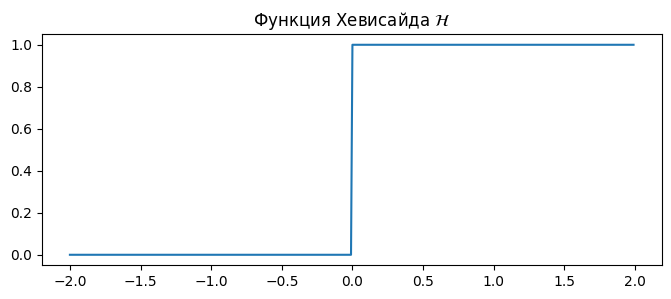

In [3]:
x = np.arange(-2,2,0.01)
y = np.heaviside(x, 1)

plt.rcParams["figure.figsize"] = (8,3)
plt.plot(x,y)
plt.title('Функция Хевисайда $\mathcal{H}$ ')
plt.show()

In [4]:
def pd_build_up(td, td_p):
    """
    расчет давления для запуска и последующей остановки скважины
    td - время после запуска
    td_p - время безразмерное - которое скважина работала до остановки
    """
    
    # применение функции Хевисайда здесь делает расчет корректным
    # для входных векторов td
    return pd_ei(td) - np.heaviside(td-td_p,1) * pd_ei(td-td_p)
    

Для связи безразмерных переменных с размерными используем переводные функции из пакета welltest.
Команда help() может помочь вспомнить список параметров, которые необходимы для корректного перевода безразмерных переменных в размерные и обратно.

In [7]:
help(td_from_t)

Help on function td_from_t in module welltest.functions:

td_from_t(t_hr, k_mD=10, phi=0.2, mu_cP=1, ct_1atm=1e-05, rw_m=0.1)
    dimension time conversion to dimensionless time
    t_hr - dimensional time, hour
    k_mD - formation permeability, mD
    phi - porosity, fractions of units
    mu_cP - dynamic fluid viscosity, cP
    ct_1atm - total compressibility, 1/atm
    rw_m - well radius, m



In [9]:
t_arr = np.logspace(-10, 2, 1000)
t_prod_hr = 24
k = 10   # проницаемость
q = 30   # дебит

# переведем размерный массив времени в безразмерные величины
# некоторые параметры можно было бы пропустить и оставить значения по умолчанию
# но для полноты приведем их в явном виде

td_arr = td_from_t(t_arr, k_mD=k, phi=0.2, mu_cP=1, ct_1atm=1e-05, rw_m=0.1)
td_prod = td_from_t(t_prod_hr, k_mD=k, phi=0.2, mu_cP=1, ct_1atm=1e-05, rw_m=0.1)

print('время работы скважины {:.2f} часа, что соответсвует безразмерному времени {:.2f}'.format(t_prod_hr, td_prod))

время работы скважины 24.00 часа, что соответсвует безразмерному времени 4320000.00


In [10]:
# для заданного массива безразмерных времен рассчитаем безразмерные давления
pd_arr = pd_build_up(td_arr, td_prod)

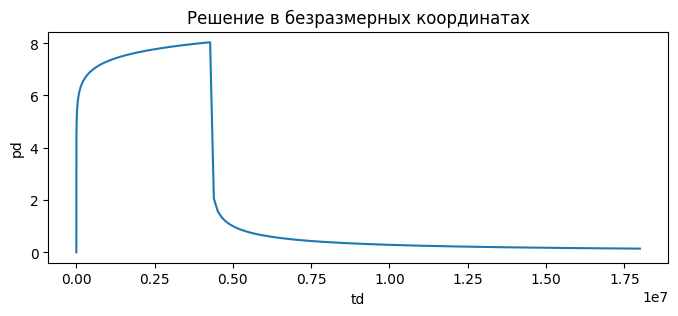

In [11]:
plt.rcParams["figure.figsize"] = (8,3)

plt.plot(td_arr, pd_arr)

plt.xlabel('td')
plt.ylabel('pd')
plt.title('Решение в безразмерных координатах')
plt.show()

In [12]:
help(p_from_pd_atma)

Help on function p_from_pd_atma in module welltest.functions:

p_from_pd_atma(pd, k_mD=10, h_m=10, q_sm3day=20, b_m3m3=1.2, mu_cP=1, pi_atma=250)
    conversion of dimensionless pressure to dimensional pressure, result in absolute atmospheres
    pd - dimensionless pressure
    k_mD - formation permeability, mD
    h_m - reservoir thickness, m
    q_sm3day - flow rate at the surface, m3 /day in s.c.
    fvf_m3m3 - oil volumetric ratio, m3/m3
    mu_cP - dynamic viscosity of fluid, cP
    pi_atma - initial pressure, absolute atm



In [14]:
# переведем безразмерные координаты в размерные
p_arr = p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250)

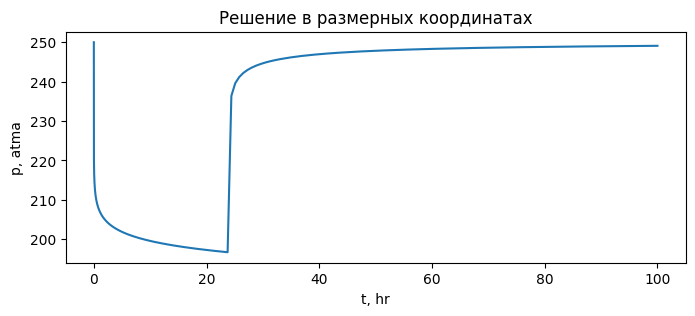

In [15]:
plt.rcParams["figure.figsize"] = (8,3)
plt.plot(t_arr, p_arr)
plt.xlabel('t, hr')
plt.ylabel('p, atma')
plt.title('Решение в размерных координатах')
plt.show()

Нарисуем распределение давления в пласте при запуске и остановке скважины.
Начнем с запуска скважины - нарисуем график изменения давления в пласте для разных моментов времени

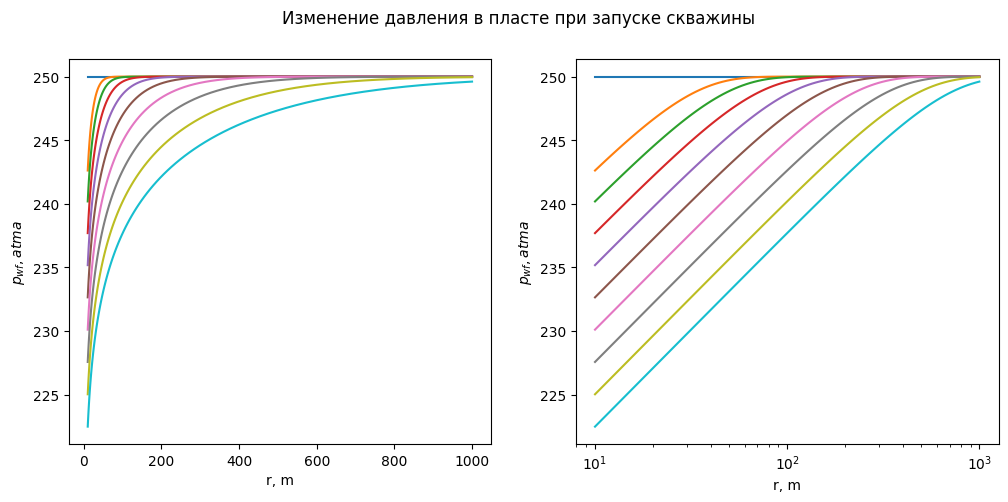

In [18]:
r_arr = np.logspace(1, 3, 100)
t_arr = np.logspace(-1, 2, 10)
t_arr[0] = 0
t_prod = 100

tv, rv = np.meshgrid(td_from_t(t_arr),rd_from_r(r_arr))
pd_arr =pd_ei(tv, rd=rv)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5])
fig.suptitle('Изменение давления в пласте при запуске скважины')
ax1.plot(r_arr, p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax1.set_label(t_arr)
ax1.set_xlabel('r, m')
ax1.set_ylabel('$p_{wf}, atma$')

ax2.plot(r_arr,p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax2.set_xscale('log')
ax2.set_xlabel('r, m')
ax2.set_ylabel('$p_{wf}, atma$')
plt.show()

Дальше нарисуем графики изменения давления в пласте для различных моментов времени после остановки скважины

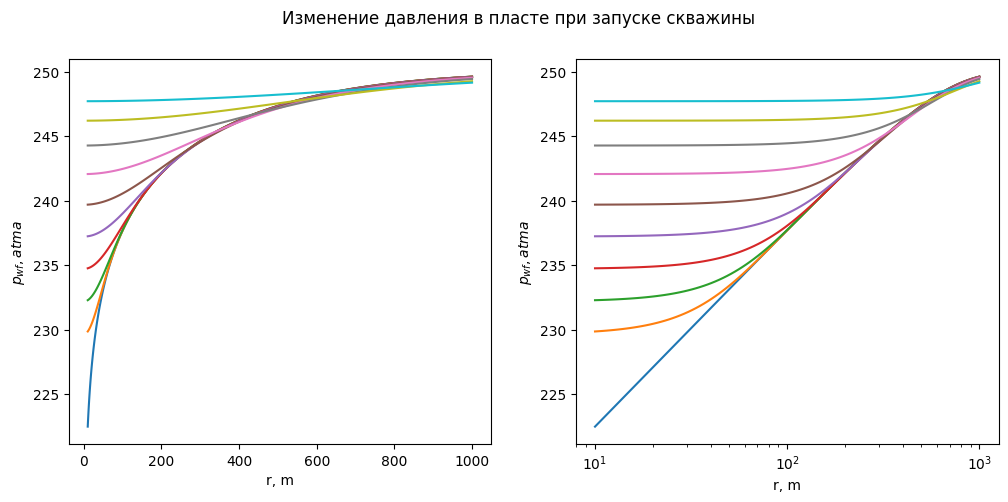

In [19]:
pd_arr_bu =pd_ei(tv + td_from_t(t_prod), rd=rv) - pd_ei(tv, rd=rv)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5])
fig.suptitle('Изменение давления в пласте при остановке скважины')
ax1.plot(r_arr, p_from_pd_atma(pd_arr_bu, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax1.set_label(t_arr)
ax1.set_xlabel('r, m')
ax1.set_ylabel('$p_{wf}, atma$')

ax2.plot(r_arr,p_from_pd_atma(pd_arr_bu, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax2.set_xscale('log')
ax2.set_xlabel('r, m')
ax2.set_ylabel('$p_{wf}, atma$')
plt.show()

Ну и нарисуем все вместе, чтобы посмотреть что получится

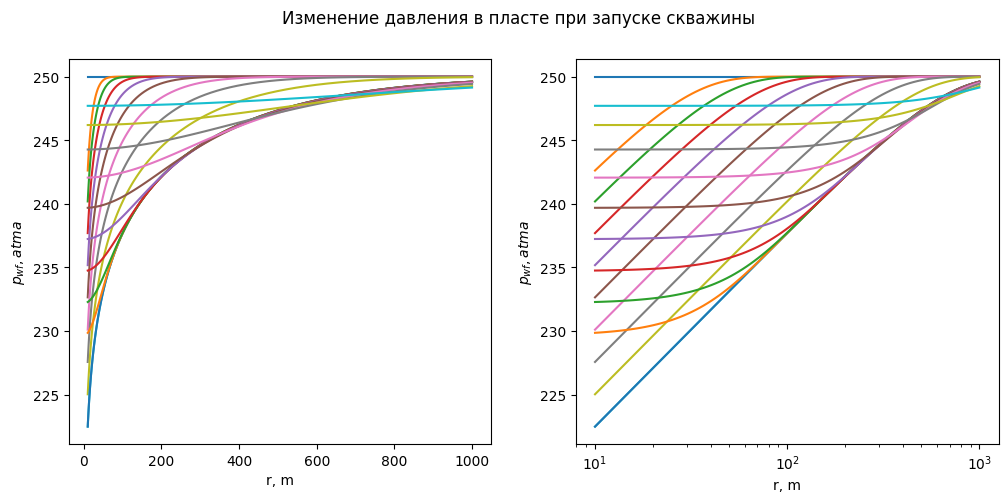

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = [12,5])
fig.suptitle('Изменение давления в пласте при запуске и остановке скважины')
ax1.plot(r_arr,p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax1.plot(r_arr,p_from_pd_atma(pd_arr_bu, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax1.set_label(t_arr)
ax1.set_xlabel('r, m')
ax1.set_ylabel('$p_{wf}, atma$')
ax2.plot(r_arr,p_from_pd_atma(pd_arr, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))
ax2.plot(r_arr,p_from_pd_atma(pd_arr_bu, k_mD=k, q_sm3day=q, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250))

ax2.set_xscale('log')
ax2.set_xlabel('r, m')
ax2.set_ylabel('$p_{wf}, atma$')
plt.show()

 * Нарисуйте анимацию изменения давления в пласте после запуска и остановки скважины на основе приведенного расчета

# 14.2 Случай для произвольной истории дебитов (ступенчатое изменение дебита) <a class="anchor" id="14.2"></a>

In [21]:
# создадим историю изменения дебитов 

t_history = np.array([ 0., 2., 24. ], dtype=np.float64) 
q_history = np.array([10., 5., 0.], dtype=np.float64)

# массивы должны быть одной и той же длины

Для расчета изменения давления при переменном дебите введем произвольное референсное значение дебита $ q_{ref} $ (например первое не нулевое значение дебита при запуске скважины). Используем это значение для определения безразмерного давления.
$$ p_D = \frac{kh}{ 18.41 q_{ref} B \mu} \left( p_i - p \right) $$

и безразмерного дебита 

$$q_D = \frac{q}{q_{ref}}$$

Тогда, используя принцип суперпозиции, можем выписать выражение для изменения давления на скважине и вокруг нее для произвольного момента времени

$$P_{mr.D}(t_D, r_D) = \sum_i \left[ q_{D(i)}-q_{D(i-1)} \right] \cdot p_D\left(t_D-t_{D(i)}, r_D\right)\cdot \mathcal{H}(t_D-t_{D(i)}) \tag{14.2} $$

где

* $i$ - индекс значения дебита в таблице изменения дебитов
* $q_{D(i)}$ - безразмерный дебит с номером $i$, который стартует в момент времени $t_i$. Для первого момента времени $i$ дебит следующий перед ним считается равным нулю
* $t_{D(i)}$ - безразмерный момент времени - включения дебита с номером $i$
* $t_{D}$ - безразмерный момент времени для которого проводится расчет
* $\mathcal{H}$ - ступенчатая [функция Хевисайда](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0#:~:text=%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F%20%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0%20%D1%88%D0%B8%D1%80%D0%BE%D0%BA%D0%BE%20%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D1%83%D0%B5%D1%82%D1%81%D1%8F%20%D0%B2,%D0%B4%D0%BB%D1%8F%20%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%B8%20%D1%8D%D0%BC%D0%BF%D0%B8%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9%20%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8%20%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F.)
* $p_D\left(t\right)$ - зависимость безразмерного давление от времени - решение задачи запуска скважины с постоянным единичным дебитом
* $P_{mr.D} $ - безразмерное давление $P_{mr.D}(t_D, r_D)$ учитывающее историю изменения дебитов скважины

In [22]:
def pd_superposition(td, td_hist, qd_hist):
    """
    расчет безразмерного давления для последовательности безразмерных дебитов
    td -  время расчета после запуска, безразмерное
    td_hist - массив времен изменения режимов работы скважин, безразмерное
    qd_hist - массив дебитов установленных после изменения режима работы, безразмерное
    """
    # принудительно добавим нули во входные массивы, чтобы учесть запуск скважины
    qdh = np.hstack([0, qd_hist])
    tdh = np.hstack([0, td_hist])
    # построим дебиты виртуальных скважин - разности реальных дебитов при переключении
    delta_qd = np.hstack([0, np.diff(qdh)])
    # референсный безразмерный дебит это 1
    
    # векторная магия - время может быть вектором и переключения дебитов тоже вектор
    # надо организовать сумму по временам, каждая из котороых сумма по переключениям
    # делаем при помощи расчета meshgrid и поиска накопленных сумм
    qd_v, td_v =np.meshgrid(delta_qd, td)
    # используем куммулятивную сумму numpy для того что суммировать результаты
    dpd = np.cumsum(qd_v * pd_ei((td_v - tdh)) * np.heaviside((td_v - tdh), 1),1 )
    # последний столбец - полная сумма, которая нужна в качестве результата
    return dpd[:,-1]


def q_superposition(t, t_hist, q_hist):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    t_hist_hr - массив времен изменения режимов работы скважин
    q_hist_sm3day - массив дебитов установленных после изменения режима работы
    """
    def interpolate_constant(x, xp, yp):
        indices = np.searchsorted(xp, x, side='right')
        y = np.concatenate(([0], yp))
        return y[indices]

    q=[]
    for ti in t:
        q.append(interpolate_constant(ti, t_hist, q_hist))
    return q

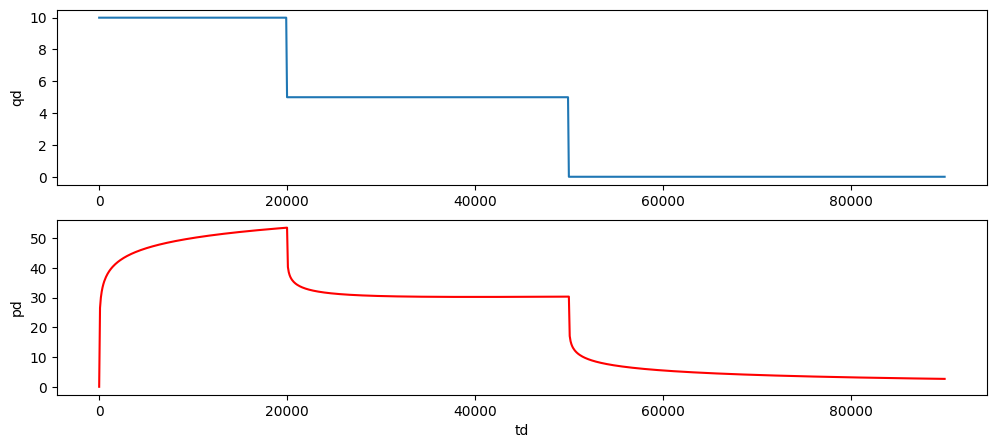

In [23]:
td_arr = np.linspace(1e-3, 9e4, 1000)


td_history = np.array([ 0., 2e4, 5e4 ], dtype=np.float64) 
qd_history = np.array([10., 5., 0.], dtype=np.float64)

plt.rcParams["figure.figsize"] = (12,5)
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(td_arr, q_superposition(td_arr, td_history, qd_history)) 
ax2.plot(td_arr, pd_superposition(td_arr, td_history, qd_history), color='red') 
ax2.set_xlabel('td')
ax1.set_ylabel('qd')
ax2.set_ylabel('pd')
plt.show()

In [35]:
def p_superposition_atma(t_hr, t_hist_hr, q_hist_sm3day,
                         k_mD=10, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250, phi=0.2, 
                         ct_1atm=1e-05, rw_m=0.1):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    t_hist_hr - массив времен изменения режимов работы скважин
    q_hist_sm3day - массив дебитов установленных после изменения режима работы
    k_mD=10 - проницаемость, мД, 
    h_m=10 - мощность пласта, м, 
    b_m3m3=1.2 - объемный коэффициент, м3/м3, 
    mu_cP=1 - вязкость нефти, сП, 
    pi_atma=250 - начальное давление, атм, 
    phi=0.2 - пористость, доли единиц, 
    ct_1atm=1e-05 - общая сжимаемость, 1/атм, 
    rw_m=0.1 - радиус скважины
    """
    q_ref=1.
    return p_from_pd_atma(pd_superposition(td_from_t(t_hr, k_mD=k_mD, phi=phi, mu_cP=mu_cP, 
                                                     ct_1atm=ct_1atm, rw_m=rw_m),
                                           td_from_t(t_hist_hr, k_mD=k_mD, phi=phi, mu_cP=mu_cP, 
                                                     ct_1atm=ct_1atm, rw_m=rw_m),
                                           q_hist_sm3day / q_ref), 
                          k_mD=10, h_m=10, q_sm3day=q_ref, b_m3m3=1.2, mu_cP=1, pi_atma=250)



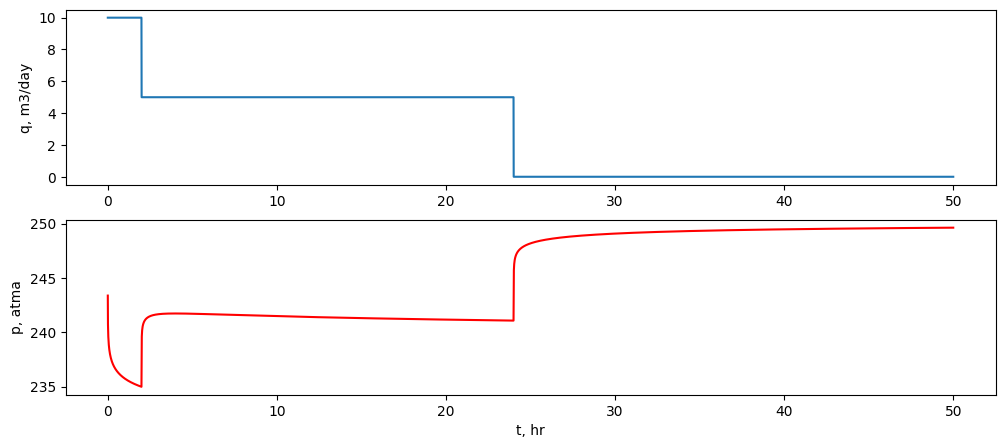

In [36]:
t_arr = np.arange(1e-3, 50, 1e-2)
plt.rcParams["figure.figsize"] = (12,5)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(t_arr, q_superposition(t_arr, t_history, q_history)) 
ax2.plot(t_arr, p_superposition_atma(t_arr, t_history, q_history), color='red') 
ax2.set_xlabel('t, hr')
ax1.set_ylabel('q, m3/day')
ax2.set_ylabel('p, atma')
plt.show()

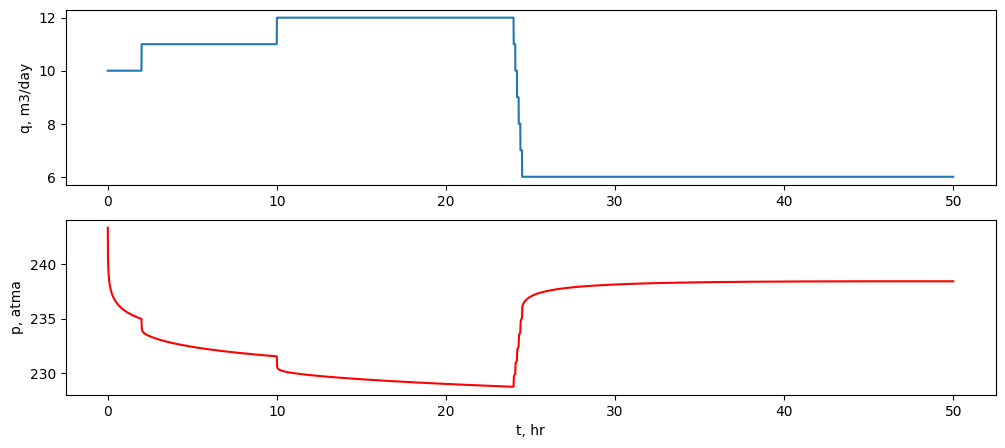

In [37]:

t_history = np.array([0, 2, 10, 24, 24.1,24.2,24.3,24.4,24.5 ])
q_history = np.array([10, 11, 12, 11, 10, 9, 8, 7, 6])

plt.rcParams["figure.figsize"] = (12,5)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(t_arr, q_superposition(t_arr, t_history, q_history)) 
ax2.plot(t_arr, p_superposition_atma(t_arr, t_history, q_history), color='red') 
ax2.set_xlabel('t, hr')
ax1.set_ylabel('q, m3/day')
ax2.set_ylabel('p, atma')
plt.show()

# 14.3 Случай для произвольной истории дебитов (линейное изменение дебита) <a class="anchor" id="14.3"></a>

Для линейно меняющегося дебита во времени (как и для любой другой зависимости) надо решение проинтегрировать по времени (надо бы подробнее расписать - сделать это позже, например как у Щелкачева в основах нестационарной фильтрации на стр 321).

Для линейной зависимости дебита от времени 
$$Q_D = dQ_D \cdot t_D $$
можно получить выражение
$$p_D(r_D,t_D, dQ_D) =-\frac{dQ_D t_D }{2} \left[ \left( 1+ \frac{r_D^2}{4 t_D} \right) Ei \left(- \dfrac{r_D^2}{4t_D} \right) + e^{-\dfrac{r_D^2}{4t_D}} \right] \tag{14.3}$$ 

где $dQ_D$ - скорость изменения дебита.

Для таблично заданных дебитов и времен можно оценить 

$$dQ_{D(i)} = \dfrac{Q_{D(i)}-Q_{D(i-1)}}{t_{D(i)} - t_{D(i-1)} } \tag{14.4}$$

Cравните формулу (14.3) с формулой (9.68) в книге Щелкачева "Основы неустановившейся фильтрации"

Тогда, используя принцип суперпозиции, можем выписать выражение для изменения давления на скважине и вокруг нее для произвольного момента времени

$$P_{mr.D}(t_D, r_D) = \sum_i  p_D\left(t_D-t_{D(i)}, r_D, dQ_{D(i+1)} - dQ_{D(i)}\right)\cdot \mathcal{H}(t_D-t_{D(i)}) \tag{14.5} $$

где

* $i$ - индекс значения дебита в таблице изменения дебитов
* $dQ_{D(i)}$ - изменение безразмерного дебита относительно безразмерного времени (14.4) 
* $t_{D(i)}$ - безразмерный момент времени - включения дебита с номером $i$
* $t_{D}$ - безразмерный момент времени для которого проводится расчет
* $\mathcal{H}$ - ступенчатая [функция Хевисайда](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0#:~:text=%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F%20%D0%A5%D0%B5%D0%B2%D0%B8%D1%81%D0%B0%D0%B9%D0%B4%D0%B0%20%D1%88%D0%B8%D1%80%D0%BE%D0%BA%D0%BE%20%D0%B8%D1%81%D0%BF%D0%BE%D0%BB%D1%8C%D0%B7%D1%83%D0%B5%D1%82%D1%81%D1%8F%20%D0%B2,%D0%B4%D0%BB%D1%8F%20%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%B8%20%D1%8D%D0%BC%D0%BF%D0%B8%D1%80%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9%20%D1%84%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D0%B8%20%D1%80%D0%B0%D1%81%D0%BF%D1%80%D0%B5%D0%B4%D0%B5%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F.)
* $p_D\left(t\right)$ - зависимость безразмерного давление от времени - решение задачи запуска скважины с постоянным единичным дебитом
* $P_{mr.D} $ - безразмерное давление $P_{mr.D}(t_D, r_D)$ учитывающее историю изменения дебитов скважины

следует обратить внимание, при суперпозиции скорость изменения дебита вычисляется как $dQ_{D(i+1)} - dQ_{D(i)}$.  при реализации расчета необходимо предусмотреть, чтобы для первого и последнего шага расчет прошел корректно. Для этого можно, например, добавить к массивам дебитов и времени дополнительный значения в начале и в конце массивов соответствующие постоянным значениям дебита. 

Также надо учитывать, что в приведенном выражении массивы должны начинаться со значений $Q_D=0$


In [20]:
import sympy as sp

In [21]:
x = sp.symbols('x')
rd, td = sp.symbols('r_d t_d')

In [22]:
# запишем решение в символьном виде
e = sp.expint(1, rd **2 / 4 / td)
e

expint(1, r_d**2/(4*t_d))

In [23]:
# проинтегрируем решение по времени
sp.integrate(e, td)

r_d**2*expint(1, r_d**2/(4*t_d))/4 + t_d*expint(1, r_d**2/(4*t_d)) - t_d*exp(-r_d**2/(4*t_d))

In [41]:
# Решение линейного стока уравнения фильтрации
def pd_lin_ei(td, rd=1, dqd_dtd=1):
    """
    Решение линейного стока уравнения фильтрации
    rd - безразмерное расстояние
    td - безразмерное время
    """
    # при расчете убедимся, что td=0 не повлияет на расчет, 
    # даже если td массив и нулевой только один элемент
    td = np.array(td, dtype = float)
    pd =  (1 + rd**2/4/td) * (-expi(-rd**2 / 4 /td)) - np.exp(-rd**2 / 4 /td)
    return dqd_dtd * td * pd / 2

In [42]:
def pd_superposition_lin(td, td_hist, qd_hist):
    """
    расчет безразмерного давления для последовательности безразмерных дебитов
    td -  время расчета после запуска, безразмерное
    td_hist - массив времен изменения режимов работы скважин, безразмерное
    qd_hist - массив дебитов установленных после изменения режима работы, безразмерное
    """
    # принудительно добавим нули во входные массивы, чтобы учесть запуск скважины
    qdh = np.hstack([qd_hist])
    tdh = np.hstack([td_hist])
    # построим дебиты виртуальных скважин - разности реальных дебитов при переключении
    delta_qd = np.hstack([np.diff(qdh),0])
    delta_td = np.hstack([np.diff(tdh),1])
    
    dq_dt = delta_qd / delta_td
    dq_dt = np.diff(np.hstack([0, delta_qd / delta_td]))
    
    # референсный безразмерный дебит это 1
    
    # векторная магия - время может быть вектором и переключения дебитов тоже вектор
    # надо организовать сумму по временам, каждая из котороых сумма по переключениям
    # делаем при помощи расчета meshgrid и поиска накопленных сумм
    qd_v, td_v =np.meshgrid(delta_qd, td)
    
    dpd = np.cumsum(pd_lin_ei((td_v - tdh), dqd_dtd=dq_dt) * np.heaviside((td_v - tdh), 1),1 )

    return dpd[:,-1]

def p_superposition_lin_atma(t_hr, t_hist_hr, q_hist_sm3day,
                         k_mD=10, h_m=10, b_m3m3=1.2, mu_cP=1, pi_atma=250, phi=0.2, 
                         ct_1atm=1e-05, rw_m=0.1):
    """
    расчет давления для запуска и последующей остановки скважины
    t_hr - время после запуска в часах
    t_hist_hr - массив времен изменения режимов работы скважин
    q_hist_sm3day - массив дебитов установленных после изменения режима работы
    k_mD=10 - проницаемость, мД, 
    h_m=10 - мощность пласта, м, 
    b_m3m3=1.2 - объемный коэффициент, м3/м3, 
    mu_cP=1 - вязкость нефти, сП, 
    pi_atma=250 - начальное давление, атм, 
    phi=0.2 - пористость, доли единиц, 
    ct_1atm=1e-05 - общая сжимаемость, 1/атм, 
    rw_m=0.1 - радиус скважины
    """
    q_ref=1.
    return p_from_pd_atma(pd_superposition_lin(td_from_t(t_hr, k_mD=k_mD, phi=phi, mu_cP=mu_cP, 
                                                     ct_1atm=ct_1atm, rw_m=rw_m),
                                               td_from_t(t_hist_hr, k_mD=k_mD, phi=phi, mu_cP=mu_cP, 
                                                     ct_1atm=ct_1atm, rw_m=rw_m),
                                               q_hist_sm3day / q_ref), 
                          k_mD=10, h_m=10, q_sm3day=q_ref, b_m3m3=1.2, mu_cP=1, pi_atma=250)


построим графики для безразмерных времен

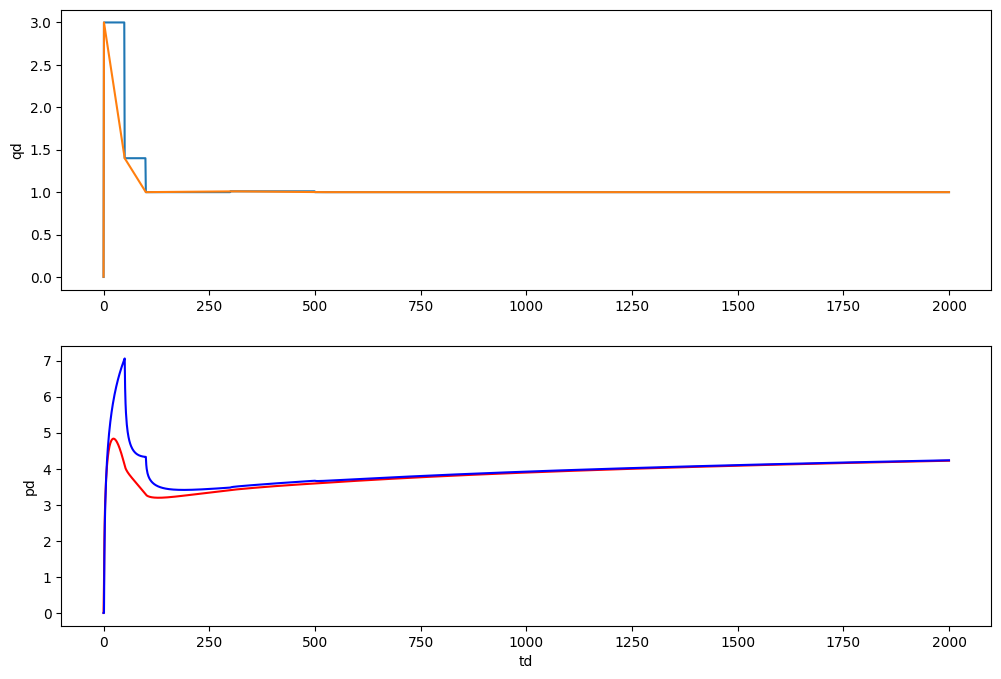

In [43]:
td_arr = np.linspace(1e-3, 2000, 2000)


td_history = np.array([0., 1, 50, 100, 300, 500 ], dtype=np.float64) 
qd_history = np.array([0., 3, 1.4, 1.0, 1.01, 1], dtype=np.float64)

plt.rcParams["figure.figsize"] = (12,8)
fig, (ax1, ax2) = plt.subplots(2,1)

ax1.plot(td_arr, q_superposition(td_arr, td_history, qd_history)) 
ax1.plot(td_arr, np.interp(td_arr, td_history, qd_history)) 
ax2.plot(td_arr, pd_superposition_lin(td_arr, td_history, qd_history), color='red') 
ax2.plot(td_arr, pd_superposition(td_arr, td_history, qd_history), color='blue') 
ax2.set_xlabel('td')
ax1.set_ylabel('qd')
ax2.set_ylabel('pd')
plt.show()

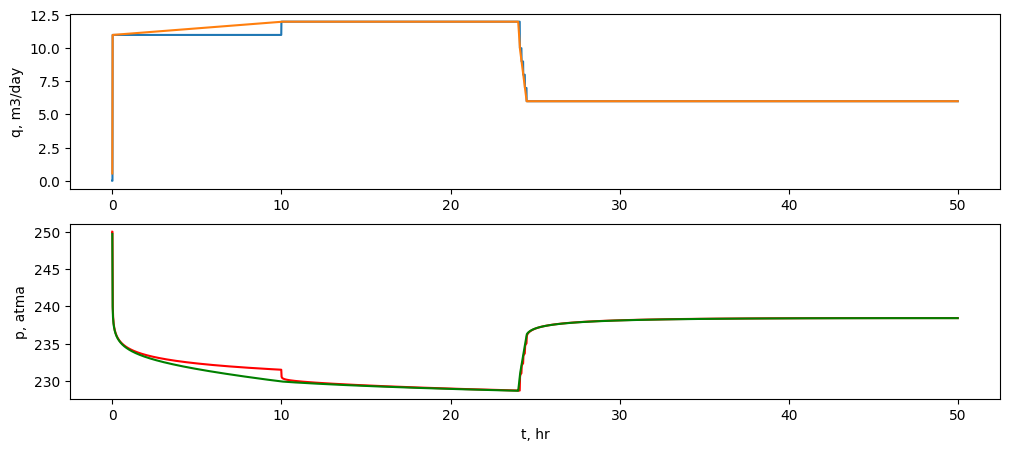

In [44]:

t_history = np.array([0, .02, 10, 24, 24.1,24.2,24.3,24.4,24.5 ])
q_history = np.array([0, 11, 12, 12, 10, 9, 8, 7, 6])

plt.rcParams["figure.figsize"] = (12,5)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(t_arr, q_superposition(t_arr, t_history, q_history)) 
ax1.plot(t_arr, np.interp(t_arr, t_history, q_history)) 
ax2.plot(t_arr, p_superposition_atma(t_arr, t_history, q_history), color='red') 
ax2.plot(t_arr, p_superposition_lin_atma(t_arr, t_history, q_history), color='green') 
ax2.set_xlabel('t, hr')
ax1.set_ylabel('q, m3/day')
ax2.set_ylabel('p, atma')
plt.show()

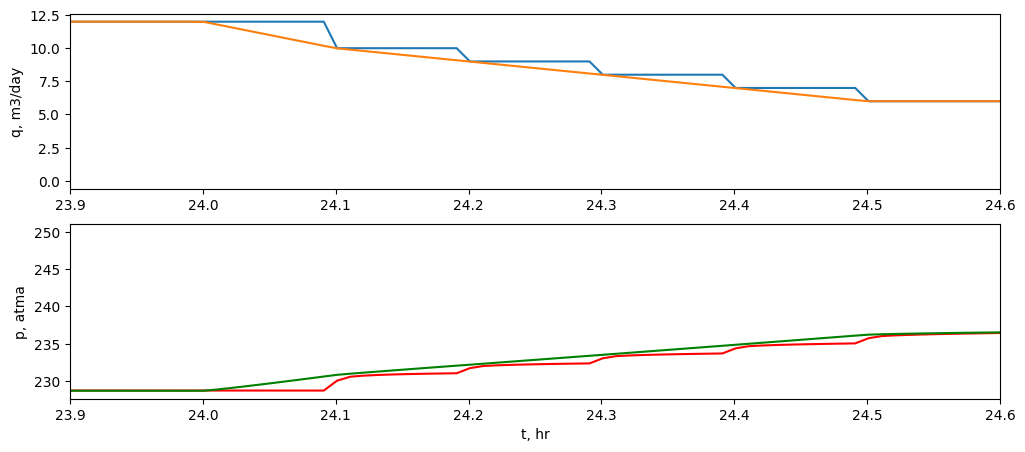

In [45]:
t_history = np.array([0, .02, 10, 24, 24.1,24.2,24.3,24.4,24.5 ])
q_history = np.array([0, 11, 12, 12, 10, 9, 8, 7, 6])

plt.rcParams["figure.figsize"] = (12,5)

fig, (ax1, ax2) = plt.subplots(2,1)
ax1.plot(t_arr, q_superposition(t_arr, t_history, q_history)) 
ax1.plot(t_arr, np.interp(t_arr, t_history, q_history)) 
ax2.plot(t_arr, p_superposition_atma(t_arr, t_history, q_history), color='red') 
ax2.plot(t_arr, p_superposition_lin_atma(t_arr, t_history, q_history), color='green') 
ax2.set_xlabel('t, hr')
ax1.set_ylabel('q, m3/day')
ax2.set_ylabel('p, atma')
ax1.set_xlim([23.9,24.6])
ax2.set_xlim([23.9,24.6])
plt.show()